---
#### 5. Load and preprocess somatic mutations from [TCGA in BigQuery]
(https://bigquery.cloud.google.com/table/isb-cgc:TCGA_hg38_data_v0.Somatic_Mutation?pli=1)
<a id="tcga"></a>

- Subset query has already been completed in BQ and saved to Google Cloud Storage

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os; os.chdir("..")
from tools.config   import TCGA_MUT,GENE2VEC,FIGURES

In [3]:
tcga_raw = pd.read_csv(TCGA_MUT)
tcga_raw.head()

,project_short_name,case_barcode,Hugo_Symbol,Start_Position,End_Position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,One_Consequence
0,TCGA-OV,TCGA-13-0757,C16orf82,27066866,27066867,RNA,INS,-,-,ATCCAGCTGTGAGT,non_coding_transcript_exon_variant
1,TCGA-OV,TCGA-13-1477,TUBB7P,189982710,189982711,RNA,INS,-,-,GCCTCAGTGAATTCCATCTCATCCATGCCCTCGCC,non_coding_transcript_exon_variant
2,TCGA-OV,TCGA-13-1500,PABPC1P2,146587959,146587960,RNA,INS,-,-,ACCAA,non_coding_transcript_exon_variant
3,TCGA-LUSC,TCGA-22-4591,HNRNPKP3,43263117,43263118,RNA,INS,-,-,AGAGG,non_coding_transcript_exon_variant
4,TCGA-OV,TCGA-36-2545,CTC-231O11.1,160485632,160485633,RNA,INS,-,-,ACC,non_coding_transcript_exon_variant


Text(0.5, 1.0, 'Distribution of Mutation Indices by Occurrence')

Text(0.5, 0, 'Mutation Index Co-occurrence')

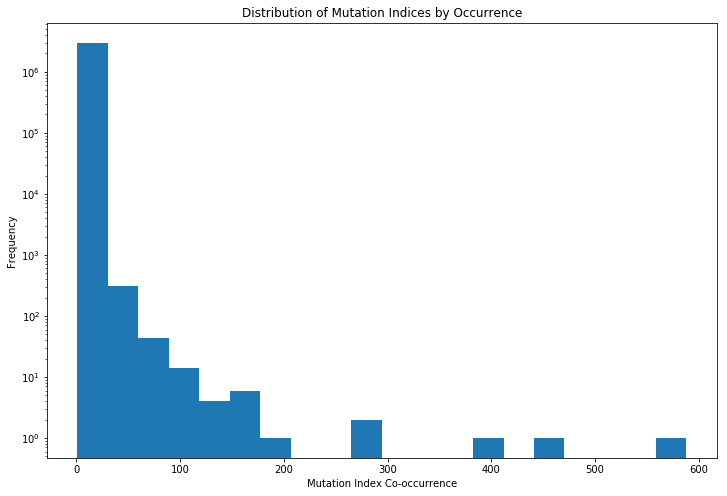

In [4]:
fig = plt.figure(figsize=(12,8)); title = 'Distribution of Mutation Indices by Occurrence'
ax = tcga_raw['Start_Position'].value_counts().plot(kind='hist', log=True,bins=20)
ax.set_title(title); ax.set_xlabel('Mutation Index Co-occurrence')
fig.savefig(FIGURES / title.lower().replace(' ','_'), dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)

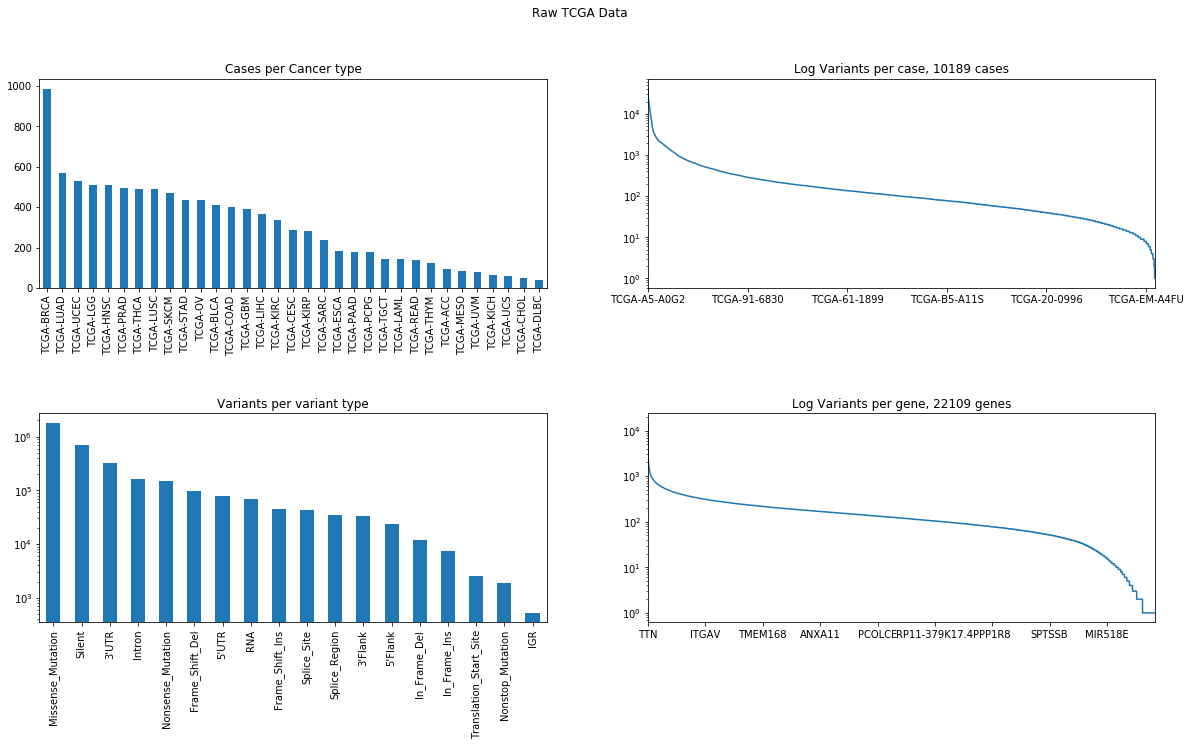

In [5]:
def visualise_distributions(df, title, savefig=True):
    """
    Plot distribution and frequency of features of interest for raw and processed TCGA df.
    """
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,10))
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.6)
    
    df.groupby('case_barcode').head(1)['project_short_name'].value_counts() \
        .plot(kind='bar', title='Cases per Cancer type', ax=axes[0,0])
    
    df['Variant_Classification'] \
        .value_counts().plot(kind='bar', title='Variants per variant type', ax=axes[1,0], logy=True)
    
    df['case_barcode'].value_counts() \
        .plot(title='Log Variants per case, {0:d} cases'
              .format(df['case_barcode'].value_counts().shape[0]), 
              ax=axes[0, 1],  logy=True)

    df['Hugo_Symbol'].value_counts() \
        .plot(title='Log Variants per gene, {0:d} genes'
              .format(df['Hugo_Symbol'].value_counts().shape[0]), 
              ax=axes[1, 1], logy=True)
    
    if savefig:
        fig.savefig(FIGURES/title.lower().replace(' ','_'), dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)
    
visualise_distributions(tcga_raw, 'Raw TCGA Data')

In absence of MutSigCV results use list of 459 driver genes from [Intogen](https://www.intogen.org/search)

In [9]:
def drop_low_mut_count(df, feature, cutoff=100):
    """
    Drop rows which contain features which occur less than cutoff times in the dataset.
    """
    subsample = df[feature].value_counts()[(df[feature].value_counts() > cutoff)].index.tolist()
    return df[df[feature].isin(subsample)]

def merge_label(df, label1, label2, merged_label):
    """
    Merge label1 and label2 into merged label within dataframe.
    """
    df.loc[(df['project_short_name'] == label1) | 
           (df['project_short_name'] == label2), 'project_short_name'] = merged_label
    return df

def process_labels(df):
    """
    Merge cancers that are established clinically to be the same.
    """
    # Colon and Rectal cancers are now considered the same cancer
    # COAD, READ -> COADREAD
    df = merge_label(df, 'TCGA-COAD', 'TCGA-READ', 'MERGE-COADREAD')
    
    # GBM and LGG are both forms of brain Glioma
    # GBM, LGG   -> GBMLGG
    df = merge_label(df, 'TCGA-GBM', 'TCGA-LGG', 'MERGE-GBMLGG')
    
    # Stomach and Esophegal cancers are also considered the same
    # ESCA, STAD -> STES
    df = merge_label(df, 'TCGA-ESCA', 'TCGA-STAD', 'MERGE-STES')
    
    return df

def filter_intogen_drivers(df):
    """
    Filter only genes that intersect with listed drivers from Intogen.
    """
    intogen_drivers = pd.read_csv(INTOGEN, sep='\t')
    driver_genes = intogen_drivers['SYMBOL'].tolist()
    return df[df['Hugo_Symbol'].isin(driver_genes)]

def filter_variants(df):
    """
    Filter out variants according to a list provided by Dr Nic Waddel (QIMR).
    """
    
    waddell_list = ['missense_variant',
                    'stop_gained',
                    'frameshift_variant',
                    'splice_acceptor_variant',
                    'splice_donor_variant',
                    'start_lost',
                    'inframe_deletion',
                    'inframe_insertion',
                    'stop_lost']
    
    return df[df['One_Consequence'].isin(waddell_list)]

---

In [10]:
df_test = (tcga_raw.pipe(process_labels)
                   .pipe(filter_variants))

X_test  = (df_test.pipe(dedup_and_get_variant_count)
                    .pipe(reshape_pivot))
        
y_test  = (df_test.pipe(get_label_df, X_test))

NameError: name 'dedup_and_get_variant_count' is not defined

In [ ]:
X_test.shape, y_test.values.flatten().shape

In [ ]:
# sklearn
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import matplotlib.pyplot as plt; import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,
                          name=None,
                          cmap='viridis',
                          savefig=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
            
    title = 'Confusion Matrices'

    # Compute confusion matrices
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            
    # Initialise plot
    fig, axes = plt.subplots(ncols=2, figsize = (20,11))
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.6)

    for i, ax in enumerate(axes):
        if i == 1:
            normalise = True
            data = cm_norm
            title = 'Normalised'
        else:
            normalise = False
            data = cm
            title = 'Non-Normalised'
            
        ax.imshow(data, interpolation='nearest')
        
#         ax.figure.colorbar()
        # We want to show all ticks...
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.1f' if normalise else 'd'
        thresh = data.max() / 2.
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt),
                        ha="center", va="center",
                        color="white" if data[i, j] < thresh else "black")
            
    fig.tight_layout()
    plt.show()
    

def run_model(X_train, y_train, model, model_name, data_name, cv=10):
    start_time = time.time()
    train_pred, acc_cv, cv_proba = fit_ml_algo(model, 
                                             X_train, 
                                             y_train, 
                                             cv)
    gbt_time = (time.time() - start_time)
    
    print("Model: %s, DataFrame: %s" % (model_name, data_name))
    print("Accuracy CV 10-Fold: %s" % acc_cv)
    print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))
    
    print(metrics.classification_report(y_train, train_pred))
    return train_pred, acc_cv, cv_proba


# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    
    cv_proba = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  method='predict_proba',
                                                  n_jobs=-1)
    
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, acc_cv, cv_proba

In [ ]:
import time; import datetime
model = {
            'model' : RandomForestClassifier(n_estimators=200, 
                                             min_samples_leaf=2,
                                             min_samples_split=17, 
                                             criterion='gini', 
                                             max_features=40)
        }

model['train_pred'], model['acc_cv'], model['cv_proba'] = run_model(X_test, y_test.values.flatten(), model['model'], 'rf', 'df_1')

plot_confusion_matrix(y_test, 
                      model['train_pred'], 
                      classes=y_test['project_short_name'].value_counts().index.values,
                      name='rf')

---

In [ ]:
# empirical dim reduction
df_proc1 = (tcga_raw.pipe(process_labels)
                    .pipe(filter_variants)
                    .pipe(filter_intogen_drivers))

# statistical dim reductions
df_proc2 = (tcga_raw.pipe(process_labels)
                    .pipe(filter_variants)
                    .pipe(drop_low_mut_count, 'Hugo_Symbol', 200))     # naïvely remove very genes with few mutations as noise

visualise_distributions(df_proc1, 'Empirical Dim Reduction')
visualise_distributions(df_proc2, 'Statistical Dim Reduction')

In [ ]:
def dedup_and_get_variant_count(df_in):
    """
    Deduplicate gene sample combinations with >1 mutations and aggregate 
    with additional feature of variant count for gene sample combination.
    """
    df = df_in.copy()
    
    counts = df.groupby('case_barcode')['Hugo_Symbol'].value_counts()
    df = df.drop_duplicates(subset=['case_barcode', 'Hugo_Symbol'])
    df = df.set_index(['case_barcode', 'Hugo_Symbol'])
    df['mutation_count'] = counts
    df = df.reset_index()
    
    return df

def reshape_pivot(df_in):
    """
    Reduce df to crucial subset then pivot on cases and genes.
    """
    df = (df_in[['case_barcode', 'Hugo_Symbol', 'mutation_count']]
              .copy()
              .pivot(index='case_barcode', columns='Hugo_Symbol', values='mutation_count')
              .fillna(0)
              .astype(int))
    
    return df

def get_label_df(df_in, df_X):
    """
    Get label df from flat processed df.
    """
    df_y = (df_in.loc[df_in['case_barcode'].isin(df_X.index)]
                 .groupby('case_barcode')
                 .head(1)
                 .set_index('case_barcode')[['project_short_name']]
                 .sort_index())
    return df_y

In [ ]:
# Get processed dataframes ready for training
df_X1 = (df_proc1.pipe(dedup_and_get_variant_count)
                 .pipe(reshape_pivot))

df_X2 = (df_proc2.pipe(dedup_and_get_variant_count)
                 .pipe(reshape_pivot))

df_y1 = (df_proc1.pipe(get_label_df, df_X1))
df_y2 = (df_proc2.pipe(get_label_df, df_X2))

In [ ]:
df_X1.head()
df_X2.head()
df_y1.head()
df_y2.head()

In [ ]:
df_X1.shape
df_y1.shape